In [19]:
"""
updated 2019-08-08 
written by Minhae Kwon

- `recoding`: Estimate the next belief from current belief and observations
    - input:
        - if you use POMDP data (for now): `recoding_pomdp_all_prev_df.csv` and `recoding_pomdp_all_now_df.csv`
        - ideally with neural data: `recoding_neural_all_prev_df.csv` and `recoding_neural_all_now_df.csv`
    - output: `recoding_belief_results_df.csv` (estimated future belief)
    - method: Autoregression - this is linear regression between two time steps. 
    - there are two versions in codes:
        -`recoding_wo_RBF.ipynb`: no RBF is used. 
        - `recoding_KRR.ipynb`: RBF is used using sklearn built-in function: [Kernel Ridge Regression (kernel ='rbf')](https://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html). 
        (Warning: this code runs pretty slow compared to others. So if you need to handle big data size, plan in advance!)
        - `recoding_manualRBF.ipynb`: RBF is manually coded by me. So we can customize center locations for nonlinear transform. 
        Everything is the same as `recoding_wo_RBF.ipynb` but RBF.
        - `recoding_KRR.ipynb` works the best, and pretty good!

ref: https://towardsdatascience.com/ridge-and-lasso-regression-a-complete-guide-with-python-scikit-learn-e20e34bcbf0b
https://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html
https://scikit-learn.org/stable/modules/linear_model.html#ridge-regression
https://scikit-learn.org/stable/auto_examples/plot_kernel_ridge_regression.html#sphx-glr-auto-examples-plot-kernel-ridge-regression-py

ref: https://chrisalbon.com/machine_learning/linear_regression/linear_regression_using_scikit-learn/
     https://datatofish.com/multiple-linear-regression-python/

cross validate score: Coefficient of determination
https://en.wikipedia.org/wiki/Coefficient_of_determination
"""

from pandas import DataFrame, read_csv
#from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import r2_score
#from sklearn.pipeline import Pipeline
from sklearn.kernel_ridge import KernelRidge
import numpy as np
import matplotlib.pyplot as plt
import itertools

#bb_df = read_csv('./data/bb_df.csv') #behavior belief =[belief for box1, beleif for box2]
bb_df_prev = read_csv('./data/recoding_pomdp_all_prev_df.csv') #behavior belief =[belief for box1, beleif for box2]
bb_df_now = read_csv('./data/recoding_pomdp_all_now_df.csv') #behavior belief =[belief for box1, beleif for box2]


TEST_SIZE = 0.2  # ratio of test data set 
N_SPLITS = 2 # "K" in K-fold cross validation 

In [20]:
data = bb_df_prev #.to_numpy()
y_raw = bb_df_now[['behavior_belief1', 'behavior_belief2']].to_numpy()


In [21]:
def RBF(X_set, centers, gamma):
    """
    gamma = 0.01: hard indicator
    gamma = 0.1: soft indicator
    """
    X_RBF_set = np.ones((X_set.shape[0], centers.shape[0])) # number of data set * number of center ponts
    for i in range(X_set.shape[0]):
        X = X_set[i] #i-th data
        X_RBF = np.exp(-1*1/gamma/2*np.linalg.norm(X-centers,2, axis = 1)**2)        
        X_RBF_set[i] = X_RBF/np.sum(X_RBF)# divided by total sum -> make total sum 1
        #print(X_RBF/np.sum(X_RBF))
    return X_RBF_set
    

In [22]:
nb_raw = data[['behavior_belief1', 'behavior_belief2']].to_numpy()#[:1000] # for time constraint, I tested only 1000 data points

a_raw = data['action'].to_numpy()#[:1000]
loc_raw = data['location'].to_numpy()#[:1000]
rwd_raw = data['reward'].to_numpy()
clr_raw = data[['color 1', 'color 2']].to_numpy()



b_center = np.linspace(0.05,1.05,11)[:10]
a_center = np.array([0,1,2,3,4])
loc_center = np.array([0, 1, 2])
rwd_center = np.array([0, 1])
clr_center = np.array([0, 1, 2, 3, 4])

# make distance =1 for belief
nb_raw = nb_raw*10
b_center = b_center*10
y_raw = y_raw*10

centers_a = []
centers_b = []
centers_loc =[]
centers_rwd = []
centers_clr =[]


for i in itertools.product(b_center,b_center):
    centers_b.append(i)
for j in itertools.product(loc_center):
    centers_loc.append(j)
for k in itertools.product(rwd_center):
    centers_rwd.append(k)
for c in itertools.product(clr_center, clr_center):
    centers_clr.append(c)
for l in itertools.product(a_center):
    centers_a.append(l)
    
centers_b = np.array(centers_b)
centers_loc = np.array(centers_loc)
centers_rwd = np.array(centers_rwd)
centers_clr = np.array(centers_clr)
centers_a = np.array(centers_a)

# nonlinear transform using RBF: belief and location are transformed individually
# gamma in here is the variance term in gaussian equation
nb = RBF(nb_raw, centers_b, gamma=0.1) 
loc = RBF(loc_raw, centers_loc, gamma=0.01) # very small gamma to act as a spike (hard indicator)
rwd = RBF(rwd_raw, centers_rwd, gamma=0.01) # very small gamma to act as a spike (hard indicator)
clr = RBF(clr_raw, centers_clr, gamma=0.01)# I'm not sure color cue needs hard or soft indicator
a = RBF(a_raw, centers_a, gamma=0.01)# very small gamma to act as a spike (hard indicator)
#y = RBF(y_raw, centers_b, gamma=0.1) 


nb_all = np.concatenate((nb, a, loc, rwd, clr),axis=1)    

In [23]:
X = nb_all
y = y_raw

### there are 3 types of data: test data, train data, validation data

In [24]:
# separate test data set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state = 1)

In [25]:
regr = LinearRegression(n_jobs = -1) # linear regression is used for encoding process
#regr = KernelRidge(alpha=0.01, gamma=0.1, kernel='rbf') # linear regression(small gamma) with RBF kernel

In [26]:
# now we use only train data 
# why use StratifiedKFold?: The folds are made by preserving the percentage of samples for each class.
k_fold = StratifiedKFold(n_splits=N_SPLITS) # seperate train data and validation data

In [27]:
# why argmax(1)? split cannot simply handle multidimension y. 
# ref: https://stackoverflow.com/questions/48508036/sklearn-stratifiedkfold-valueerror-supported-target-types-are-binary-mul
for i, (train_index, val_index) in enumerate(k_fold.split(X, y.argmax(1))):
    #print("TRAIN:", train_index, "TEST:", val_index)
    x_train_kf, x_val_kf = X[train_index], X[val_index]
    y_train_kf, y_val_kf = y[train_index], y[val_index]
    #print(x_train_kf)
    #print(y_train_kf)
    regr.fit(x_train_kf, y_train_kf) # fit the model
    nb_val = regr.predict(x_val_kf) # predict based on current model -> use validation data for evaluation
    print('score', r2_score(y_val_kf, nb_val, multioutput='raw_values')) # get r2 score

score [0.56781343 0.60143358]
score [0.56436018 0.59676093]


### Linear regression model: 

In [28]:
regr.coef_.shape

(2, 135)

In [29]:
print('Intercept: ', regr.intercept_)
print('Coef: ', regr.coef_)

Intercept:  [-6.53114927e+11  1.77989185e+12]
Coef:  [[ 5.05449603e+11  5.05449603e+11  5.05449603e+11  5.05449603e+11
   5.05449603e+11  5.05449603e+11  5.05449603e+11  5.05449603e+11
   5.05449603e+11  5.05449603e+11  5.05449603e+11  5.05449603e+11
   5.05449603e+11  5.05449603e+11  5.05449603e+11  5.05449603e+11
   5.05449603e+11  5.05449603e+11  5.05449603e+11  5.05449603e+11
   5.05449603e+11  5.05449603e+11  5.05449603e+11  5.05449603e+11
   5.05449603e+11  5.05449603e+11  5.05449603e+11  5.05449603e+11
   5.05449603e+11  5.05449603e+11  5.05449603e+11  5.05449603e+11
   5.05449603e+11  5.05449603e+11  5.05449603e+11  5.05449603e+11
   5.05449603e+11  5.05449603e+11  5.05449603e+11  5.05449603e+11
   5.05449603e+11  5.05449603e+11  5.05449603e+11  5.05449603e+11
   5.05449603e+11  5.05449603e+11  5.05449603e+11  5.05449603e+11
   5.05449603e+11  5.05449603e+11  5.05449603e+11  5.05449603e+11
   5.05449603e+11  5.05449603e+11  5.05449603e+11  5.05449603e+11
   5.05449603e+11  5.05

### evaluate model with test data

In [30]:
predic_X_test = regr.predict(X_test)

recoding_error = y_test - predic_X_test # true - estimate
print('recoding MSE: \n', np.mean(recoding_error**2, axis=0))
print('recoding error std:\n', np.std(recoding_error, axis=0))      
print('score', r2_score(y_test, predic_X_test, multioutput='raw_values'))

recoding MSE: 
 [3.65012071 3.77049308]
recoding error std:
 [1.9104938  1.94170495]
score [0.57675097 0.60284301]


In [31]:
predic_X_df_test = DataFrame(predic_X_test) 

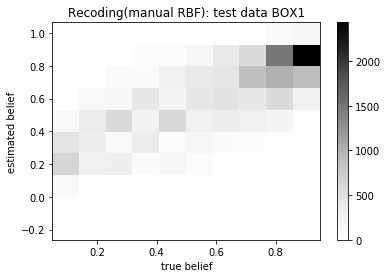

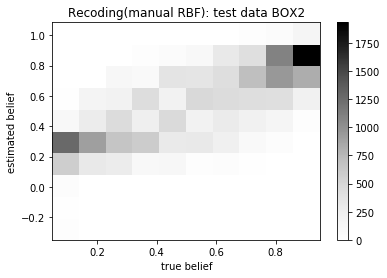

In [32]:
# plot: compare raw data vs prediction
plt.hist2d(y_test[:,0]/10, predic_X_test[:,0]/10, bins=(10, 10), cmap=plt.cm.Greys)
plt.colorbar()
plt.xlabel('true belief')
plt.ylabel('estimated belief')
plt.title('Recoding(manual RBF): test data BOX1')
plt.savefig('./figures/recoding_manualRBF_box1.eps', format = 'eps')

# plot: compare raw data vs prediction
plt.figure()
plt.hist2d(y_test[:,1]/10, predic_X_test[:,1]/10, bins=(10, 10), cmap=plt.cm.Greys)
plt.colorbar()
plt.xlabel('true belief')
plt.ylabel('estimated belief')
plt.title('Recoding(manual RBF): test data BOX2')
plt.savefig('./figures/recoding_manualRBF_box1.eps', format = 'eps')

Text(0.5, 1.0, 'Recoding: BOX 2')

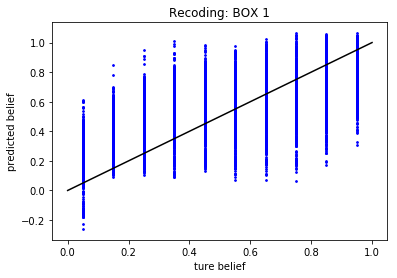

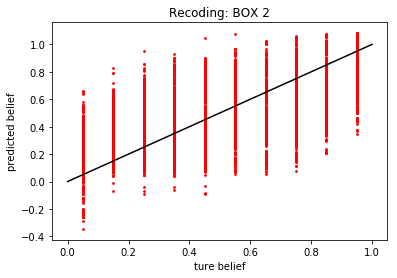

In [33]:
line_x = np.linspace(0,1,num=11)
line_y = np.linspace(0,1,num=11)
S = 3


# plot: compare raw data vs prediction
plt.scatter(y_test[:,0]/10, predic_X_test[:,0]/10, s=S, c='blue', marker='o')
plt.plot(line_x, line_y,c='k')
plt.xlabel('ture belief')
plt.ylabel('predicted belief')
plt.title('Recoding: BOX 1')

# plot: compare raw data vs prediction
plt.figure()
plt.scatter(y_test[:,1]/10, predic_X_test[:,1]/10, s=S, c='red', marker='o')
plt.plot(line_x, line_y,c='k')
plt.xlabel('ture belief')
plt.ylabel('predicted belief')
plt.title('Recoding: BOX 2')

In [34]:
y_raw

array([[3.5, 8.5],
       [7.5, 6.5],
       [5.5, 6.5],
       ...,
       [0.5, 2.5],
       [0.5, 1.5],
       [1.5, 5.5]])

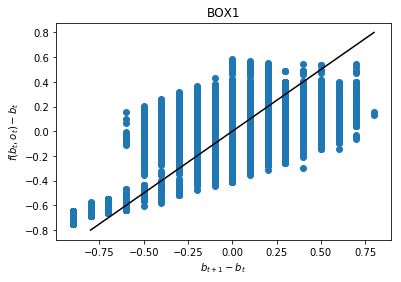

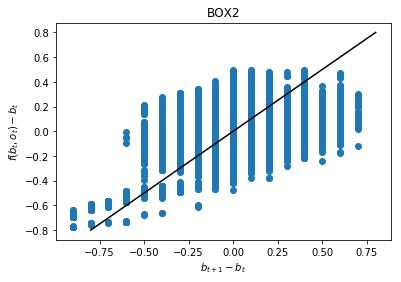

In [35]:
# plot changes

line_x = np.linspace(-.8,.8,num=11)
line_y = np.linspace(-.8,.8,num=11)

true_change = (y_raw - nb_raw)/10
predic_X = regr.predict(X) # all data
predicted_change = (predic_X - nb_raw)/10

plt.scatter(true_change[:,0], predicted_change[:,0])
plt.plot(line_x, line_y,c='k')
plt.xlabel('$b_{t+1}-b_t$')
plt.ylabel('$f(b_t, o_t)-b_t$')
plt.title('BOX1')
plt.savefig('./figures/recoding_DELTA_manualRBF_box1.eps', format = 'eps')

plt.figure()
plt.scatter(true_change[:,1], predicted_change[:,1])
plt.plot(line_x, line_y,c='k')
plt.xlabel('$b_{t+1}-b_t$')
plt.ylabel('$f(b_t, o_t)-b_t$')
plt.title('BOX2')
plt.savefig('./figures/recoding_DELTA_manualRBF_box2.eps', format = 'eps')


### build csv file

In [261]:
"""
#neural estimate of belief using current linear regression model
nb= regr.predict(r_df) 
nb_df = DataFrame(nb, columns = bb_df.columns)
#save neural estimate belief
nb_df.to_csv(path_or_buf='./data/nb_df.csv',index=False)
"""

"\n#neural estimate of belief using current linear regression model\nnb= regr.predict(r_df) \nnb_df = DataFrame(nb, columns = bb_df.columns)\n#save neural estimate belief\nnb_df.to_csv(path_or_buf='./data/nb_df.csv',index=False)\n"